In [0]:
import numpy as np
import random
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt


def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))

def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 2)))

def distribution3(batch_size=512):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 1)))

e = lambda x: np.exp(x)
tanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))
def distribution4(batch_size=1):
    # arbitrary sampler
    f = lambda x: tanh(x*2+1) + x*0.75
    while True:
        yield(f(np.random.normal(0, 1, (batch_size, 1))))


In [0]:
#estimate JSD and WD
def estimate(metric, dist1, dist2, D):
    x_1 = torch.from_numpy(next(dist1)).float()
    x_2 = torch.from_numpy(next(dist2)).float()
    y_1 = D(x_1)
    y_2 = D(x_2)

    if metric == 'JSD':
        y_1 = torch.sigmoid(y_1)
        y_2 = torch.sigmoid(y_2)
        jsd = np.log(2) + (0.5*torch.mean(torch.log(y_1)) + 0.5*torch.mean(torch.log(1 - y_2))).data.cpu().numpy()
        return jsd
    if metric == 'WD':
        wd = (torch.mean(y_1) - torch.mean(y_2)).data.cpu().numpy()
        return wd
    

In [0]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt
#import samplers
import argparse

#Three Layer MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size

        self.layer1 = nn.Linear(self.input_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        out = torch.relu(self.layer1(x))
        out = torch.relu(self.layer2(out))
        out = self.layer3(out)
        return out

#Train method
def train(metric, dist1, dist2):
    
    D = MLP(2)
    sgd = SGD(D.parameters(), lr=0.001)
    
    if metric == 'WD':
        dist_u = distribution2(batch_size=512)
        lambda_ = 10

    for i in range(40000):
        sgd.zero_grad()
        x_1 = torch.from_numpy(next(dist1)).float()
        x_2 = torch.from_numpy(next(dist2)).float()
        y_1 = D(x_1)
        y_2 = D(x_2)

        if metric == 'JSD':
            y_1 = torch.sigmoid(y_1)
            y_2 = torch.sigmoid(y_2)
            loss = - torch.mean(torch.log(y_1)) - torch.mean(torch.log(1 - y_2))
        if metric == 'WD':
            num = torch.from_numpy(next(dist_u)).float()
            x_z = num*x_1 + (1 - num)*x_2
            x_z.requires_grad = True
            y_z = D(x_z)
            grad_z = torch.autograd.grad(y_z, x_z, grad_outputs=torch.ones(y_z.size()), retain_graph=True, create_graph=True, only_inputs=True)[0]
            loss = -(torch.mean(y_1) - torch.mean(y_2) - lambda_*torch.mean((torch.norm(grad_z, p=2, dim=1)-1)**2))
            
        loss.backward()
        sgd.step()

    return D

x = -1.0
x = -0.9
x = -0.8
x = -0.7
x = -0.6
x = -0.5
x = -0.4
x = -0.3
x = -0.2
x = -0.1
x = -0.0
x = 0.1
x = 0.2
x = 0.3
x = 0.4
x = 0.5
x = 0.6
x = 0.7
x = 0.8
x = 0.9
x = 1.0


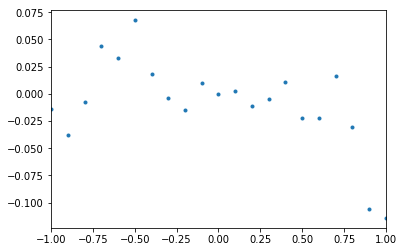

In [15]:
#Testing
# data_points = ([],[])
# dist1 = distribution1(0)
# for x in np.arange(-1.0, 1.01, 0.1):
#     x = np.around(x, decimals=1)
#     print("x = " + str(x))
#     dist2 = distribution1(x, batch_size=512)
#     D = train('WD', dist1, dist2)
#     y = estimate('WD', dist1, dist2, D)
#     data_points[0].append(x)
#     data_points[1].append(y)

# plt.plot(data_points[0], data_points[1], '.')
# plt.xlim(-1, 1)
# plt.show()

x = -1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


x = -0.9
x = -0.8
x = -0.7
x = -0.6
x = -0.5
x = -0.4
x = -0.3
x = -0.2
x = -0.1
x = -0.0
x = 0.1
x = 0.2
x = 0.3
x = 0.4
x = 0.5
x = 0.6
x = 0.7
x = 0.8
x = 0.9
x = 1.0


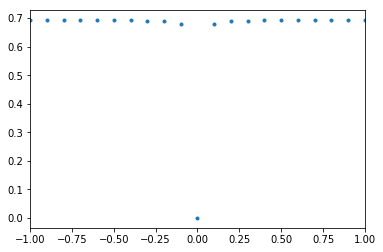

In [0]:
#plot JSD
data = ([],[])
dist1 = distribution1(0)
for x in np.arange(-1.0, 1.01, 0.1):
    x = np.around(x, decimals=1)
    print("x = " + str(x))
    dist2 = distribution1(x, batch_size=512)
    D = train('JSD', dist1, dist2)
    y = estimate('JSD', dist1, dist2, D)
    data[0].append(x)
    data[1].append(y)

plt.plot(data_points[0], data_points[1], '.')
plt.xlim(-1, 1)
plt.show()

x = -1.0
x = -0.9
x = -0.8
x = -0.7
x = -0.6
x = -0.5
x = -0.4
x = -0.3
x = -0.2
x = -0.1
x = -0.0
x = 0.1
x = 0.2
x = 0.3
x = 0.4
x = 0.5
x = 0.6
x = 0.7
x = 0.8
x = 0.9
x = 1.0


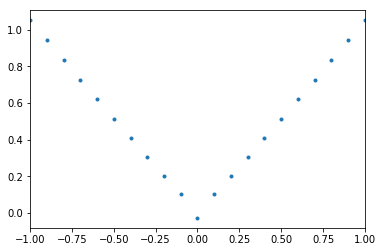

In [0]:
#plot WD
data = ([],[])
dist1 = distribution1(0)
for x in np.arange(-1.0, 1.01, 0.1):
    x = np.around(x, decimals=1)
    print("x = " + str(x))
    dist2 = distribution1(x)
    D = train('WD', dist1, dist2)
    y = estimate('WD', dist1, dist2, D)
    data[0].append(x)
    data[1].append(y)

plt.plot(data[0], data[1], '.')
plt.xlim(-1, 1)
plt.show()